In [1]:
import os
os.chdir("/opt/gildemeister/gildemeister-implementation")


In [2]:
import pickle

import numpy as np
import torch

from cids.util import misc_funcs as misc
from cids.data import SCVICCIDSDataset, SCVIC_CIDS_CLASSES_INV

import matplotlib.pyplot as plt
from cids.data import get_SCVIC_dataloader, get_SCVIC_dataloader_binary

In [3]:
root_path = misc.data_raw(scvic=True)
print(root_path)


/work/gildemeister/SCVIC-CIDS-2021


# Basic Raw Data inspection

In [7]:
with open(os.path.join(root_path, "CidsSampleAttack_Tensor_28.pkl"), "rb") as f:
    attack = pickle.load(f)
with open(os.path.join(root_path, "CidsSampleNormal_Tensor_28.pkl"), "rb") as f:
    normal = pickle.load(f)


In [22]:
data = attack + normal

network_minmax = torch.tensor([[float('inf')] * data[0][0].shape[0], [-float('inf')] * data[0][0].shape[0]])
host_minmax = torch.tensor([[float('inf')] * data[0][1].shape[1], [-float('inf')] * data[0][1].shape[1]])
print(network_minmax.shape)
print(host_minmax.shape)

for point in data:
    network_minmax[0] = torch.minimum(network_minmax[0], point[0])
    network_minmax[1] = torch.maximum(network_minmax[1], point[0])
    host_minmax[0] = torch.minimum(host_minmax[0], torch.min(point[1], dim=0).values)
    host_minmax[1] = torch.maximum(host_minmax[1], torch.max(point[1], dim=0).values)

torch.Size([2, 132])
torch.Size([2, 8])


In [32]:
print(network_minmax.requires_grad)

False


In [33]:
point = data[0]
print(host_minmax)
print(((point[1] - host_minmax[0]) / (host_minmax[1] - host_minmax[0])).requires_grad)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -9.2234e+18,  0.0000e+00],
        [ 5.1047e+04,  1.0000e+00,  4.9152e+04,  4.0000e+00,  7.0050e+03,
          6.9000e+01,  4.6117e+18,  7.7000e+01]])
False


In [25]:
print(network_minmax)
print(host_minmax)

torch.save(
    {
        "network_minmax": network_minmax,
        "host_minmax": host_minmax
    }, os.path.join(root_path, "minmax.pt")
)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.2000e+01, 4.2000e+01, 4.2000e+01, 4.2000e+01, 4.2000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

In [34]:
test = torch.load(os.path.join(root_path, "minmax.pt"))
print(test["network_minmax"].requires_grad)

False


/tmp/ipykernel_3418799/2462544164.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(os.path.join(root_path, "minmax.pt"))


In [12]:
data = normal
print(type(data))
print(len(data))
print(type(data[0]))
print(len(data[0]))
for i in range(0, len(data), 10000):
    print(f"Analyse field {i}")
    for d in data[i]:
        print(f"\t{type(d)}")
        if isinstance(d, torch.Tensor):
            print(f"\t{d.size()}")
        else:
            print(f"\t{d}")

<class 'list'>
460547
<class 'tuple'>
4
Analyse field 0
	<class 'torch.Tensor'>
	torch.Size([132])
	<class 'torch.Tensor'>
	torch.Size([28, 8])
	<class 'str'>
	The Amazon SSM Agent service terminated unexpectedly.  It has done this 208 time(s).  The following corrective action will be taken in 30000 milliseconds: Restart the service. The Amazon SSM Agent service terminated with the following service-specific error: 
Incorrect function. The Amazon SSM Agent service entered the stopped state.
	<class 'str'>
	Benign
Analyse field 10000
	<class 'torch.Tensor'>
	torch.Size([132])
	<class 'torch.Tensor'>
	torch.Size([28, 8])
	<class 'str'>
	The Amazon SSM Agent service terminated unexpectedly.  It has done this 29 time(s).  The following corrective action will be taken in 30000 milliseconds: Restart the service. The Amazon SSM Agent service terminated with the following service-specific error: 
Incorrect function. The Amazon SSM Agent service entered the stopped state.
	<class 'str'>
	Benign

In [ ]:
ssm_counter = 0
for i in range(len(normal)):
    if "Amazon SSM Agent" in normal[i][2]:
        ssm_counter += 1
print(f"SSM Counter: {ssm_counter}\nTotal: {len(normal)}")
print(f"SSM Counter: {ssm_counter/len(normal)}")

SSM Counter: 411829
Total: 460547
SSM Counter: 0.8942170940208057


: 

: 

In [ ]:
ssm_counter = 0
for i in range(len(attack)):
    if "Amazon SSM Agent" in attack[i][2]:
        ssm_counter += 1
print(f"SSM Counter: {ssm_counter}\nTotal: {len(attack)}")
print(f"SSM Counter: {ssm_counter/len(attack)}")

SSM Counter: 88222
Total: 460547
SSM Counter: 0.1915591676853828


: 

: 

In [ ]:
with open(os.path.join(root_path, "Msg2Vec_Bert_100.pkl"), "rb") as f:
            msg2vec = pickle.load(f)

: 

: 

In [ ]:
print(type(msg2vec))
print(len(msg2vec))
print(type(msg2vec[0]))
print(type(msg2vec[0][0]))
print(msg2vec[0][3])
print(type(msg2vec[1]))
print(msg2vec[1].shape)
print(len(msg2vec[0]))

<class 'tuple'>
2
<class 'list'>
<class 'str'>
The AppX Deployment Service (AppXSVC) service entered the stopped state. The Amazon SSM Agent service terminated unexpectedly.  It has done this 10 time(s).  The following corrective action will be taken in 30000 milliseconds: Restart the service. The Amazon SSM Agent service terminated with the following service-specific error: 
Incorrect function. The Amazon SSM Agent service entered the stopped state.
<class 'torch.Tensor'>
torch.Size([13077, 100, 768])
13077


: 

: 

In [ ]:
data = normal + attack

: 

: 

In [ ]:
occurences = {}
for d in data:
    if d[3] in occurences:
        occurences[d[3]] += 1
    else:
        occurences[d[3]] = 1
print(occurences)

{'Benign': 460547, 'Bot': 90460, 'DoS-SlowHTTPTest': 15930, 'DoS-Hulk': 19941, 'Brute Force -Web': 42, 'Brute Force -XSS': 16, 'SQL Injection': 15, 'Infiltration': 29, 'DoS-GoldenEye': 3434, 'DoS-Slowloris': 2096, 'DDOS-LOIC-HTTP': 58185, 'DDOS-LOIC-UDP': 1102, 'FTP-BruteForce': 48140, 'SSH-Bruteforce': 16561, 'DDOS-HOIC': 204596}


: 

: 

# Analyse Dataset

In [4]:
ds = SCVICCIDSDataset(root_path)

In [5]:
def plot_occurences(ds, idx=None):
    occurences = {}
    idx = idx if idx is not None else list(range(len(ds)))
    for i in idx:
        d = ds[i]
        if SCVIC_CIDS_CLASSES_INV[d[3]] in occurences:
            occurences[SCVIC_CIDS_CLASSES_INV[d[3]]] += 1
        else:
            occurences[SCVIC_CIDS_CLASSES_INV[d[3]]] = 1

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.bar(occurences.keys(), occurences.values(), color="slateblue")
    ax.set_xticklabels(occurences.keys(), rotation=90, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)  # Set fontsize for y-ticks
    ax.set_ylabel("Number of network flows", fontsize=14)
    ax.set_yscale("log")
    fig.tight_layout()
    fig.savefig("plots/transformer/distribution_scvic.pdf")
    plt.show()

/tmp/ipykernel_4054760/3210585381.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(occurences.keys(), rotation=90, fontsize=14)


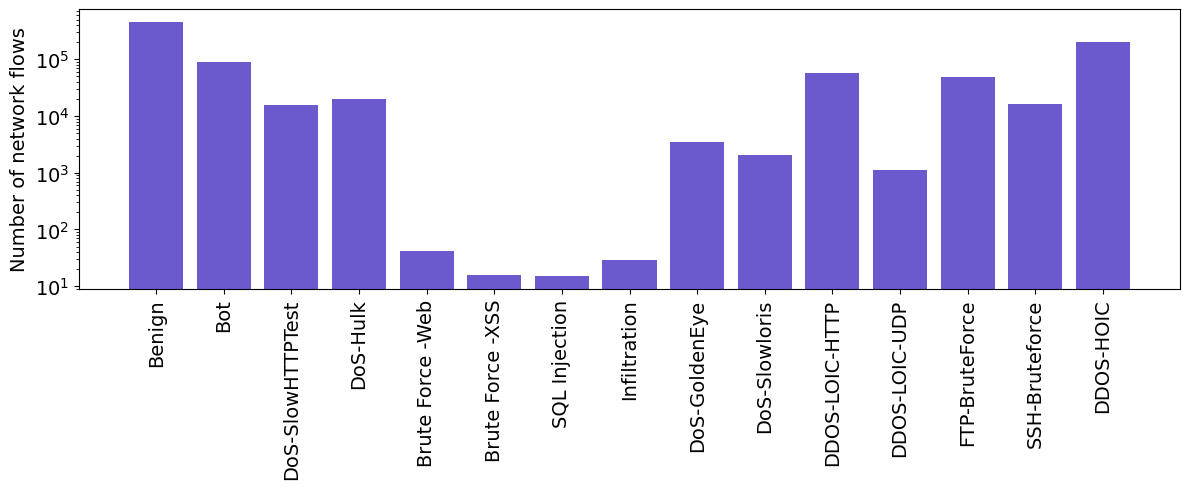

In [6]:
plot_occurences(ds)

In [6]:
labels = []
for i in range(len(ds)):
    labels.append(ds[i][3])

<class 'numpy.ndarray'>


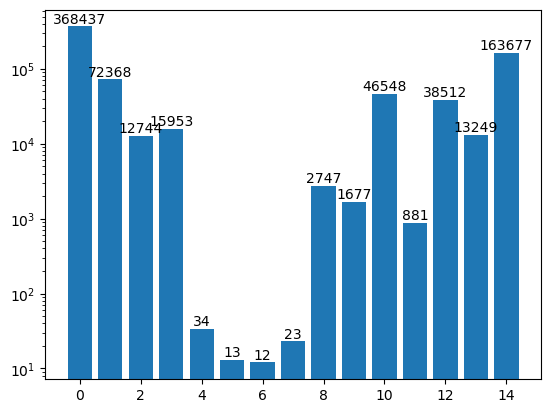

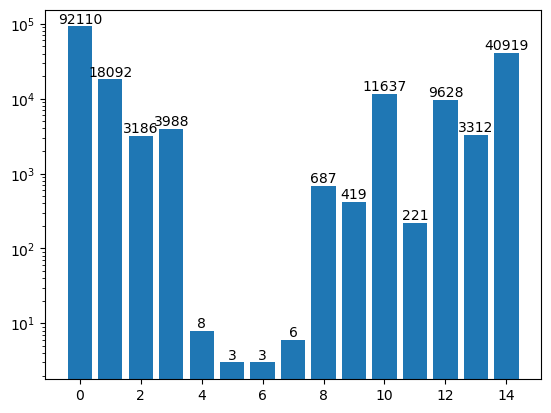

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

train, test = sss.split(np.zeros(len(labels)), labels).__next__()
print(type(train))
plot_occurences(ds, train)
plot_occurences(ds, test)

np.savetxt(os.path.join(misc.data(), "scvic/train_indices.txt"), train, fmt="%d")
np.savetxt(os.path.join(misc.data(), "scvic/test_indices.txt"), test, fmt="%d")

In [19]:
ds_leftout = SCVIC_CIDS_Dataset(root_path, exclude=["DDOS-HOIC"])

KeyboardInterrupt: 

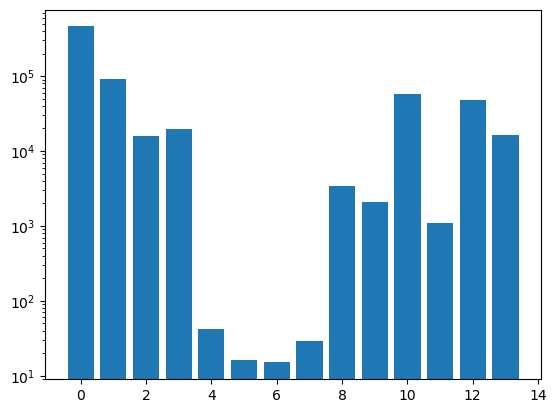

In [8]:
occurences = {}
for i in range(len(ds_leftout)):
    d = ds_leftout[i]
    if d[3] in occurences:
        occurences[d[3]] += 1
    else:
        occurences[d[3]] = 1

plt.bar(occurences.keys(), occurences.values())
plt.yscale("log")
plt.show()

# test Dataloader

In [5]:
train, val = get_SCVIC_dataloader_binary(8, 1)

In [7]:
for t in train:
    print(t[0].size(), t[1].size(), t[2].size(), t[3].size())
    print(t[3])
    break
for v in val:  
    print(v[0].size(), v[1].size(), v[2].size(), v[3].size())
    print(v[3])
    break
print(len(train), len(val))


torch.Size([8, 132]) torch.Size([8, 28, 8]) torch.Size([8, 100, 768]) torch.Size([8])
tensor([1, 1, 1, 0, 1, 1, 1, 1])
torch.Size([8, 132]) torch.Size([8, 28, 8]) torch.Size([8, 100, 768]) torch.Size([8])
tensor([1, 1, 1, 0, 1, 0, 1, 0])
73688 18422


In [8]:
test = get_SCVIC_dataloader(8, 1, test=True, validation=False)
for t in test:
    print(t[0].size(), t[1].size(), t[2].size(), t[3].size())
    break
print(len(test))

torch.Size([8, 132]) torch.Size([8, 28, 8]) torch.Size([8, 100, 768]) torch.Size([8])
23028


Start plotting


KeyboardInterrupt: 

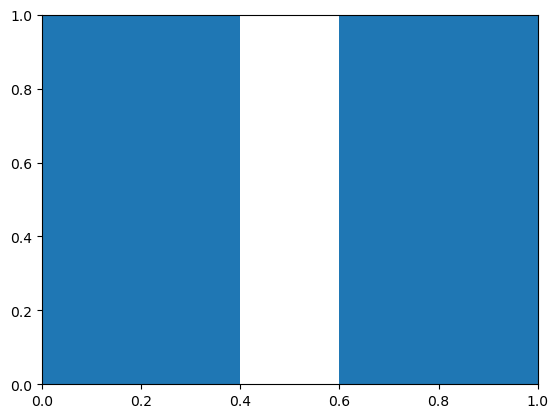

In [12]:
occurences = {}
for j, b in enumerate(val):
    for i in range(b[0].size(0)):
        if b[3][i] in occurences:
            occurences[b[3][i]] += 1
        else:
            occurences[b[3][i]] = 1
print("Start plotting")
plt.bar(occurences.keys(), occurences.values())
plt.yscale("log")

plt.show()